In [1]:
import pandas as pd
import numpy as np
import time

In [5]:
%time df = pd.read_pickle('nyc-2017-yellow-taxi-trips-to-airport-expanded.pkl.gz')

CPU times: user 6.23 s, sys: 2.18 s, total: 8.41 s
Wall time: 8.57 s


In [6]:
df.columns

Index(['pickup_datetime', 'dropoff_datetime', 'pickup_borough', 'pickup_zone',
       'pickup_service_zone', 'dropoff_zone', 'dropoff_month',
       'drop_off_week_of_year', 'dropoff_day_of_year', 'dropoff_day_of_month',
       ...
       'dropoff_hour_14', 'dropoff_hour_15', 'dropoff_hour_16',
       'dropoff_hour_17', 'dropoff_hour_18', 'dropoff_hour_19',
       'dropoff_hour_20', 'dropoff_hour_21', 'dropoff_hour_22',
       'dropoff_hour_23'],
      dtype='object', length=756)

In [7]:
dfs = df.sample(frac=0.01, random_state=0)
X = dfs.drop(columns=['pickup_datetime', 'dropoff_datetime',
                     'pickup_borough', 'pickup_zone', 'pickup_service_zone', 'dropoff_zone',
                     'dropoff_month', 'drop_off_week_of_year', 'dropoff_day_of_year',
                     'dropoff_day_of_month', 'dropoff_hour',
                    'trip_duration_minutes']).values
y = dfs.trip_duration_minutes.values

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=0)

# Linear Regression

In [10]:
from sklearn.linear_model import LinearRegression
slr = LinearRegression(normalize=True)

In [11]:
%time slr.fit(X_train, y_train)

CPU times: user 2.36 s, sys: 190 ms, total: 2.55 s
Wall time: 1.08 s


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [12]:
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
def display_metric(name, metric, y_train, y_train_pred, y_test, y_test_pred):
    print('train: {:.3f}, test: {:.3f}'.format(metric(y_train, y_train_pred), metric(y_test, y_test_pred)))

In [14]:
display_metric('MAE', mean_absolute_error, y_train, y_train_pred, y_test, y_test_pred)

train: 22.757, test: 161440370154435.062


In [15]:
display_metric('MSE', mean_squared_error, y_train, y_train_pred, y_test, y_test_pred)

train: 5520.415, test: 17917618048298889708752286515200.000


In [16]:
slr.score(X_train, y_train),slr.score(X_test, y_test)

(0.025443121921874142, -4.8203225084531786e+27)

In [18]:
slr.coef_.max()

2.4464062925733107e+17

In [2]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

ImportError: cannot import name 'get_backend' from 'matplotlib' (/Users/frank/miniconda3/lib/python3.7/site-packages/matplotlib/__init__.py)

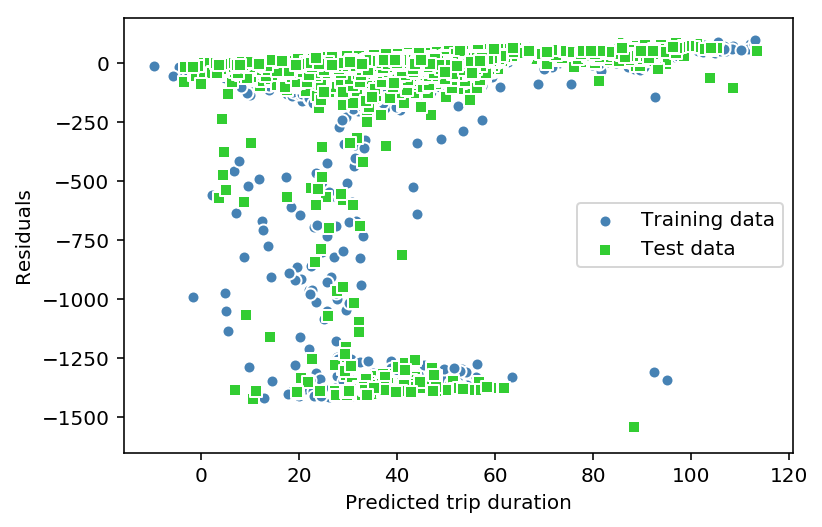

In [215]:
plt.scatter(y_train_pred, y_train_pred - y_train, c='steelblue', marker='o', edgecolors='white', label='Training data')
plt.scatter(y_test_pred, y_test_pred - y_test, c='limegreen', marker='s', edgecolors='white', label='Test data')
plt.xlabel('Predicted trip duration')
plt.ylabel('Residuals')
plt.legend()

In [216]:
y_train.shape, y_train_pred.shape,y_test.shape, y_test_pred.shape

((175685,), (175685,), (75294,), (75294,))

In [217]:
from sklearn.metrics import mean_squared_error
print("MSE train: {:.3f}, test: {:.3f}".format(mean_squared_error(y_train, y_train_pred),
                                              mean_squared_error(y_test, y_test_pred)))

MSE train: 5069.701, test: 4822.627


# RANSAC Regressor

In [218]:
from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor(LinearRegression(), max_trials=100, min_samples=10,
                         loss='absolute_loss', residual_threshold=15.0, random_state=0)

In [219]:
%time ransac.fit(X, y)

CPU times: user 4.84 s, sys: 109 ms, total: 4.95 s
Wall time: 859 ms


RANSACRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
        is_data_valid=None, is_model_valid=None, loss='absolute_loss',
        max_skips=inf, max_trials=100, min_samples=10, random_state=0,
        residual_threshold=15.0, stop_n_inliers=inf, stop_probability=0.99,
        stop_score=inf)

In [220]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(3, 10, 1)

# Random Forest Regressor

In [19]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators=1000, criterion='mse', random_state=1, n_jobs=-11)
%time forest.fit(X_train, y_train)

CPU times: user 35min 22s, sys: 3 s, total: 35min 25s
Wall time: 42min 54s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-11,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

In [20]:
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)
print("MSE train: {:.3f}, test: {:.3f}".format(mean_squared_error(y_train, y_train_pred),
                                              mean_squared_error(y_test, y_test_pred)))

MSE train: 1023.308, test: 4857.758


In [21]:
from sklearn.metrics import r2_score
print("R^2 train: {:.3f}, test: {:.3f}".format(r2_score(y_train, y_train_pred),
                                              r2_score(y_test, y_test_pred)))

R^2 train: 0.819, test: -0.307


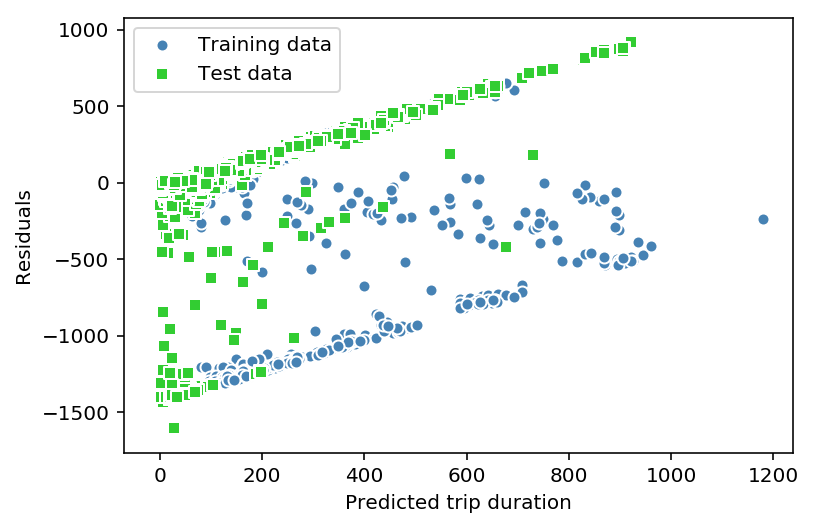

In [228]:
plt.scatter(y_train_pred, y_train_pred - y_train, c='steelblue', marker='o', edgecolors='white', label='Training data')
plt.scatter(y_test_pred, y_test_pred - y_test, c='limegreen', marker='s', edgecolors='white', label='Test data')
plt.xlabel('Predicted trip duration')
plt.ylabel('Residuals')
plt.legend()